The best solution is [  0.73828495  64.00740148]
with error equal to approximately 46.1284874025


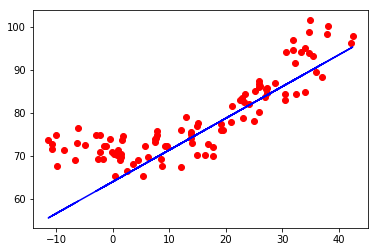

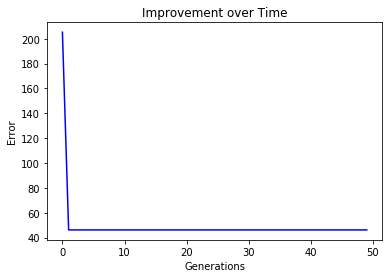

In [13]:
### Genetic algorithm to fit a regression line of the form y=ax+b to a 2-variable dataset

import random
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

# load the data
my_data_file = 'temp_data.npy'
data = np.load(my_data_file)

#collect data into lists for graphing
x = []
y = []
for row in data:
    x.append(row[0])
    y.append(row[1])
    
# parameters
initial_pop_size = 100
mutation_rate = 0.05
num_generations = 50 
chromosome_length = 2
num_survivors = 50

#2.1.a:
#initial_pop_size sets how many chromosomes the algorithm begins with.
#mutation_rate determines the probability of a chromosome being mutated.
#num_generations determines how many times a new population of chromosomes is created.
#chromosome_length sets how many genes (floating point numbers in this case) each chromosomes has. 
#The genes correspond to the coefficients of the regression line.
#num_survivors determines how many chromosomes from the current population are carried over to the new population.


# functions

#A generates the initial population of chromosomes, which each represents the slope and y-intercept of a regression line.
#It generates a gene pool of potential values for the coefficients using np.linspace (returns a list of a set number of 
# values between two points).
#It then sets the dimensions of the population array, which has one row for each chromosome and a column for each gene.
#The population is filled by randomly choosing values from the gene pool to create a new array of the previously defined dimensions.
#This array is then outputted and used in the initialization of the main program.
def A():
    gene_pool = np.linspace(-1,80,num = 5000)
    dimensions = (initial_pop_size, chromosome_length)
    return np.random.choice(gene_pool, size=dimensions, replace=False)

#B measures how fit each chromosome is by calculating the average squared error between the regression line it encodes and the 
# actual y values.
#It iterates through each data point and calculates the expected y value using the inputted coefficients encoded in the 
# chromosome and the x value.
#For each point, it finds the residual by subtracting the expected y value from the actual value.
#This value is then squared and added to the total error sum of squares so far. 
#After each point has been checked, the sum of squares is divided by the amount of data points to calculate the average, which 
# it outputs.
def B(coefficients):
    k = len(data)
    tot = 0
    for j in range(k):
        y = coefficients[0] * data[j,0] + coefficients[1]
        res = data[j,1] - y
        tot += res**2
    return tot/k

#C creates a fitness vector that pairs each chromosome with its fitness, as determined by function B.
#It iterates through each index of the current population, which each correspond to a chromosome.
#For every index, a numpy array containing it and its average error (calculated by B) is appended to a list.
#The list is then converted to a numpy array and outputted.
def C():
    fitlist = []
    for x in range(len(current_pop)):
        fitlist.append(np.array([x,B(current_pop[x])]))
    return np.array(fitlist)

#D selects a chromosome for survival based off both random choice and fitness, as calculated by B.
#It randomly chooses 25 (the number of survivors / 2) chromosomes, identified by their index on the fitness vector generated by C.
#It then selects the most fit chromosome from this randomly generated list.
#It identifies the index of this single chromosome and then locates it in the current population.
#The chromosome's coefficient values (as opposed to its index) are outputted.
def D():
    random_selection = np.random.choice(range(len(fitness_vector)), num_survivors//2, replace=False)
    best = np.argmin(fitness_vector[random_selection,1])
    best_index = random_selection[best]
    return current_pop[int(fitness_vector[best_index][0])]   

#E represents breeding and crossover to fill the new population with the offspring of the survivors selected by D.
#It creates an empty list to represent the new chromosomes that need to be created to fill the new population.
#It then iterates through the columns, which represent the slope and y-intercept coefficients.
#Each column is replaced with the corresponding survivors column, repeated 4 times (to fill the entire column).
#The order of the duplicated coefficients is then randomly rearranged, and the numpy array is outputted.
def E():
    duplicate_size = len(new_population) - len(survivors)
    duplicate_survivors = np.zeros((duplicate_size, chromosome_length))
    for x in range(chromosome_length): # for each column in the survivor array
        duplicate_survivors[:, x] = np.repeat(survivors[:, x], 4, axis=0) # duplicate column 4 times
        duplicate_survivors[:, x] = np.random.permutation(duplicate_survivors[:, x])
    return duplicate_survivors

#F should represent mutation by randomly changing chromosomes at the predetermined mutation rate. 
#This improves the likelihood of finding the best solution by randomly altering chromosomes, thereby covering more of the 
#solution space and preventing the algorithm from getting stuck in a local optimum.
#My code generates a list of values between 0-1 at 0.01 increments and randomly selects one for each gene.
#If this value is less than the mutation rate the gene is mutated; this gives each gene the same probability of being mutated as the mutation rate.
#It multiplies each gene by a mutator, from 0-1, and then replaces the original with the new version.
#The array with mutated genes is outputted.
def F(array): 
    
    mutationchance = np.linspace(0, 1, 100)

    for c in range(len(array)):
        for g in range(chromosome_length):
            
            mutationcheck = np.random.choice(mutationchance, 1)
           
            if mutationcheck < mutation_rate:
                mutator = random.random()
                mutatedgene = array[c][g] * mutator
                array[c][g] = mutatedgene
                
    return array
# #algorithms: my function takes a population array as an input and returns the mutated array, with randomly chosen altered gnes.

#G prints the original data along with the trendline the algorithm found.
#It calculates the trendline by finding the expected y value based off the current best coefficients.
def G():
    trendline = []
    slope = float(best_solution[0])
    yint = float(best_solution[1])
    for i in x:
        trendy = slope * i + yint
        trendline.append(trendy)

    plt.plot(x, y, 'ro', x, trendline, 'b-')
    plt.show()

########################################################################
# Start of main program
#These lines initialize the program by creating the original population of 100 chromosomes using A and a new population 
#of 250 chromosomes, currently filled with zeroes.
current_pop = A()
new_population = np.zeros((num_survivors * 5, chromosome_length))
#Initializes a list to store the error of the best solution, calculated by B, for every generation.
errors = []

# main loop
#A new population is created for each generation (10 in this case).
for i in range(num_generations):
    
    #C is called to create a list matching each chromosome with its fitness, calculated by B.
    fitness_vector = C()
    #An empty array (of just 0s) is created to store the chromosomes that will survive to go in to the next generation 
    # (50 in this case).
    survivors = np.zeros((num_survivors, chromosome_length))
    #This loop iterates through the survivors array, filling each index with an existing chromosome chosen by D.
    for n in range(len(survivors)):
        survivors[n] = D()
    #The survivors are inserted into the new population.
    new_population[:len(survivors)] = survivors
    #The rest of the new population is filled by breeding the survivors using E.
    new_population[len(survivors):] = E()
    
    #The chromosomes in the new population are mutated using F.
    new_population = F(new_population)
    
    #These lines reinitialize the code for the next generation.
    #The population that was just generated becomes the current population.
    current_pop = new_population
    #A new empty population is created to be filled by a new generation of chromosomes.
    new_population = np.zeros((num_survivors * 5, chromosome_length))
    
    #Calculates the fitness of each current chromosome.
    fitness_vector = C()
    
    #Determines the current best solution by finding which chromosome has the lowest error (given by argmin).
    best_solution = current_pop[np.argmin(fitness_vector[:,1])]
    #Appends the error of the current best solution to the accumulator list.
    errors.append(B(best_solution))
    


#Prints best solution, error, and graph (using G).
print("The best solution is", best_solution)
print("with error equal to approximately", B(best_solution))
G()

#Creates a graph to show how the algorithm's error improved with each generation.
plt.plot(range(num_generations), errors, 'b-')
plt.xlabel("Generations")
plt.ylabel("Error")
plt.title("Improvement over Time")
plt.show()
# #optimization: this graph visualizes how the optimization function minimizes its error over time, until a relatively
# optimal solution is found.

In [ ]:
# scipy regression function to compare with the genetic algorithm's solutions
from scipy import stats
print(stats.linregress(data)[0:2])

2.1.b: Increasing the number of survivors (to 100) slightly improves the algorithm, because they are chosen partially based off their fitness so better solutions would be more prevalent.  Increasing the mutation rate to 0.5 resulted in bigger improvements in error between the first and last generation, and a lower likelihood of the best solution not changing at all or plateauing early, because more new, random solutions were introduced. Surprisingly, increasing the number of generations (to 50) did not greatly improve solutions, since error rates tend to plateau quickly.  The algorithm often gets stuck on a single "best solution," which, depending on the initial error, may be very good or very poor, because the crossover mechanism only switches existing values (instead of averaging them as well), reducing the likelhood of a new, optimal solution being generated.  

I also attempted (mostly unsuccessfully) to find optimal parameters using another genetic regression algorithm, which I discuss further at the bottom of this page.*

2.2: This problem solves the task of finding a regression line by randomly selecting slope and y-intercept values and then testing them to see which result in the lowest average sum of squared errors between data points and the line.  It uses a combination of random selection and selection based on fitness to iterate through a set number of generations of chromosomes (composed of the two coefficients).  This means that while more fit chromosomes are more likely to survive to the end of the algorithm, the diversity of the population is maintained by including other random, less fit chromosomes and randomly mutating some.  The algorithm, therefore, covers more of the solution space and avoids getting stuck on a local minimum.  Once it has reached the last generation, the most fit solution of the surviving population is calculated, and it outputs the slope and y-intercept as a numpy array.  They can then be combined into a regression line equation, which estimates the value of one variable based on the value of the other and reflects the positive correlation between the two.  

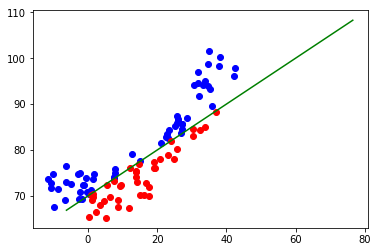

59
41


In [15]:
##LABELS DATA WITH 1 OR 0
#randomly chosen separating line:
#line = 0.5x + 70

#initialize array to store new labeled data
newdata = np.zeros((100, 3))

#iterates through each row of data, giving it a label depending on where it is in relation to the line
#and adds the new row to the new data set
for i in range(len(data)):
    
    row = data[i]
    
    if row[1] > ((0.5 * row[0]) + 70):
        row = np.concatenate((row, [0]), axis = 0)
    else:
        row = np.concatenate((row, [1]), axis = 0)
       
    newdata[i] = row

#sorts points into red and blue groups depending on their label
redx = []
bluex = []
redy = []
bluey = []

for i in newdata:
    
    if i[2] < 1: 
        bluex.append(i[0])
        bluey.append(i[1])
        
    else:
        redx.append(i[0])
        redy.append(i[1])

#generates y points to graph the separation line
sepline = []
for i in data[0]:
    y = i * 0.5 + 70
    sepline.append(y)
    
plt.plot(bluex, bluey, 'bo', redx, redy, 'ro', data[0], sepline, 'g-')
plt.show()

The best solution is: [0.5008708155459327, 69.9326171875]


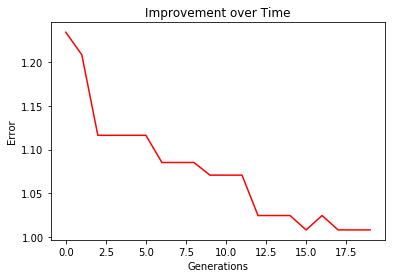

In [24]:
##genetic algorithm to find a line that best separates labeled data points

import random

#################################################################################################################################
#################################################################################################################################

#finds error by calculating how homogenous each group created by a given separation line is
def error(chrom):
    
    #retrieves line values from the chromosome
    slope = chrom[0]
    yint = chrom[1]
    
    #creates accumulators to store the number of each colored point in each group
    group10 = 0
    group11 = 0
    group20 = 0
    group21 = 0
    
    #iterates through points, testing for if they're above or below the line and their label, then increments the right group
    for p in newdata:
        if p[1] > ((slope * p[0])) + yint:
            if p[2] < 1:
                group10 = group10 + 1
            else: 
                group11 = group11 + 1
        else:
            if p[2] < 1:
                group20 = group20 + 1
            else: 
                group21 = group21 + 1
    
    #test to prevent dividing by zero if all points are on one side of the line
    #assigns error value of 5 (approximately 2 / .41 (.41 is the total number of blue points))
    if (group10 + group11) == 0 or (group20 + group21) == 0:
        return 5
    
    #calculates the homogeneity of each group
    #determines which label is the majority, then calculates its percentage
    #other group's homogeneity is automatically calculated for the other label
    if group10 > group11: 
        hom1 = group10 / (group10 + group11)
        hom2 = group21 / (group20 + group21)
    else:
        hom1 = group11 / (group10 + group11)
        hom2 = group20 / (group20 + group21)
    
    #highest homogeneity possible for each group is 1.0, so divides 2 by the sum to give a minimizable error
    return 2 / (hom1 + hom2)
            

#randomly generates an initial population of chromosomes
def makepop():
    
    #initializes variables to store all possible types of each gene
    genepool1 = []
    genepool2 = []
    
    #possible values for slope are decimals between -10 and 10
    for i in range(-100, 101):
        genepool1.append(i / 10)
        
    #possible values for y-intercept are integers between 0 and 100
    for i in range(101):
        genepool2.append(i)
    
    #initializes list to store initial population of chromosomes
    chromosomes = []
    
    #iterates through each future member of the population and randomly chooses two genes to make a chromosome
    for i in range(pop):
        newchrom = []
        newchrom.append(random.choice(genepool1))
        #selected genes are removed from the list to avoid duplicate chromosomes and encourage more diversity
        genepool1.remove(newchrom[0])
        newchrom.append(random.choice(genepool2))
        genepool2.remove(newchrom[1])

        chromosomes.append(newchrom)
    
    #returns the filled population
    return chromosomes

#creates a list to store the index of each chromosome along with its fitness
def findfit(poplist):
    
    #initializes fitness list
    fitlist = []
    
    #iterates through each chromosome, calculating its fitness using the error function and appending it to the list
    for i in poplist:
               
        fit = error(i) 
        
        #fitness is placed first so that min and max functions used in crossover functions measure fitness, not index
        fitlist.append([fit, i])
    
    #returns the list of fitnesses and indices
    return fitlist

#produces a new chromosome from two parents using one of two reproduction methods
def skoodilypooping(mom, dad):
    
    #initializes list to store new chromosome
    baby = []
    
    #randomly selects a binary value to determine which type of reproduction to use
    type = random.choice([0, 1])
    
    #the first reproduction type creates a child by averaging the values for each parent gene
    if type == 0:       
        for g in range(chromlen):        

            newgene = (mom[g] + dad[g]) / 2

            baby.append(newgene)
     
    #the second reproduction type creates a child by copying one gene from each parent
    else:
        baby.append(mom[0])
        baby.append(dad[1])
            
    #returns the new chromosome         
    return baby

#generates a new generation of chromosomes
def makegen():
    
    #copies fitness list so values can be removed (used in breeding the most fit parents below) without altering the original
    fitlist = fitnesslist[:]
    
    #initializes list to store the new population
    newpop = []
    
    #half of the new population is produced from the most fit existing chromosomes
    for i in range(int(pop / 4)):
        
        #the two minimum values are found and then removed so that the code can run multiple times without using the same values
        mom = min(fitlist)[1]
        fitlist.remove(min(fitlist))
        dad = min(fitlist)[1]
        fitlist.remove(min(fitlist))
        
        #a child is produced from the two most fit chromosomes using the breeding function and added to the new population
        baby = skoodilypooping(mom, dad)
        newpop.append(baby)
        
        #the most fit chromosomes are preserved in the new population
        newpop.append(mom)
    
    #the other half of the population is produced from randomly selected chromosomes
    for i in range(int(pop / 2)):
        #the orignial fitnesslist, which was not altered by the previous loop
        mom = random.choice(fitnesslist)[1]
        dad = random.choice(fitnesslist)[1]
        
        #a child is produced from the two chromosomes and added to the new population
        baby = skoodilypooping(mom, dad)
        newpop.append(baby)
    
    #the new population of chromosomes is outputted
    return newpop 

#randomly mutates chromosomes in the new population
def mutation():
    
    #iterates through each chromosome
    for c in newpop:
        
        #tests to see if the chromosome should be mutated using the mutation rate and random selection
        #converts the mutation rate to an integer
        newmut = int(mutrate * 100)
        #selects a random integer between 0 and 100
        mut = random.choice(range(100))   
        #if the random value is less than the converted mutation rate, it is mutated
        #this ensures that each chromosome has the correct probability of being mutated
        if mut < newmut:
            
            #initializes list to store mutated chromosome
            newchrom = []
            for g in range(len(c)):     
                
                #retrieves the original gene from the chromosome that will be mutated
                gene = c[g]
                
                #generates a random floating point value between 0 and 1, then multiplies the gene by it 
                mutator = random.random()
                gene = gene * mutator
                
                #the mutated gene is added to the mutated chromosome
                newchrom.append(gene)
        
            #the mutated gene is inserted at the index of the original (to avoid iterating through the same gene twice)
            newpop.insert(newpop.index(c), newchrom)
            #the original gene is removed from the population
            newpop.remove(c)
     
    #the new, mutated population is outputted
    return newpop

#################################################################################################################################
#################################################################################################################################

##################################################   PARAMETERS  ###############################################################

pop = 100 #must be multiple of 2 for the makegen population to function; chromosomes need to be paired off
mutrate = 0.05 
numgen = 20  
chromlen = 2


###############################################   MAIN PROGRAM    ##############################################################

#creates an initial population
currentpop = makepop()

#initializes a list to store the error of the most fit chromosome for every generation
errlist = []

#iterates through each generation
for i in range(numgen):
    
    #calculates the fitness of each current chromosome
    fitnesslist = findfit(currentpop)
    
    #generates and then mutates a new population
    newpop = makegen()   
    newpop = mutation()
    
    #calculates the fitness of each new chromosome
    fitnesslist = findfit(newpop)
    
    #finds the chromosome with the smallest error and calculates its error, which is added to the accumulator list
    bestchrom = min(fitnesslist)[1]
    besterr = error(bestchrom)
    errlist.append(besterr)
    
    #assigns the new population to the currentpop variable for the next generation
    currentpop = newpop

#prints the best solution and a graph showing how the error improved with each generation
print("The best solution is:", bestchrom)
plt.plot(range(numgen), errlist, 'r-')
plt.xlabel("Generations")
plt.ylabel("Error")
plt.title("Improvement over Time")
plt.show()

#algorithms: I wrote a list-based genetic algorithm from scratch, ignoring aspects of the original algorithm that I found unnecessary (such as making the new population larger than the initial one) and redesigning other portions, such as the crossover function, to increase the success of the algorithm.
#optimization: This algorithm attempts to find the best line of separation by preserving the best solutions and deriving new solutions from them as well as avoiding falling into a local minimum by maintaining the diversity of the population through randomly breeding solutions and mutation.  It is generally more successful than the given algorithm because it uses crossover (both averaging and recombining solutions) and mutation to generate novel solutions while ensuring that the most fit solution is never lost.

*The code I wrote to optimize the parameters of the original regression algorithm is attached in a separate file, to avoid both cluttering this notebook and potentially crashing it.  My code does function, but is currently not likely to return optimal parameters because it is attempting to optimize a stochastic function.  This means that the same set of parameters would probably produce a different error list each time they are inputted into the original genetic regression algorithm, so calculated fitness could be arbitrarily high or low.  A more powerful computer could do a better job of calculating fitness by running a given chromosome through the original function multiple times and finding the average improvement, but this is much too computationally expensive for my laptop, which (I discovered after I had begun writing this program) can hardly run my existing code.